In [58]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import random

from keras import layers
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras import models
from keras import optimizers
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras import applications

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import glob
import os
from datetime import datetime

In [59]:
img_src_folder = "lung-segmentation/uniq"
os.listdir(img_src_folder)

['p17',
 'p5',
 'p7',
 'multigif.py',
 'p13',
 'p11',
 'p16',
 'p6',
 'p8',
 'p15',
 'p14',
 'p1',
 'p4',
 'p18',
 'p3',
 'p19',
 'p12',
 'p9',
 'p10',
 'p2',
 'gifs.zip',
 'p20']

In [60]:
#1-5: normal patients, 11-20: covid patients.
other_patients = []
covid_patients = []
for root, dirs, files in os.walk(img_src_folder):
    for d in dirs:
        if d[0] == 'p':
            num = int(d[1:])
            if num <= 10: other_patients.append(d)
            elif num >= 11: covid_patients.append(d)


In [61]:
sorted(other_patients)

['p1', 'p10', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9']

In [62]:
sorted(covid_patients)

['p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20']

In [63]:
now = datetime.now()
#defining the minimum number of patients of each class that will be in the test set.
test_patients_per_label = 0
#building the test set with the declared num of patients of each class
TEST_IMG_FOLDERS = sorted(other_patients)[0:test_patients_per_label]
TEST_IMG_FOLDERS = sorted(covid_patients)[0:test_patients_per_label]

#splitting the test data and the rest (training and validation)
if test_patients_per_label > 0:
    for n in range(test_patients_per_label):
        other_patients.pop(0)
        covid_patients.pop(0)
        
#defining the number of patients in training set
num_train_patients = int(0.8*min(len(other_patients), len(covid_patients)))
        
train_other_folders = sorted(other_patients)[0:num_train_patients]
train_label_1 = ['other' for i in range(len(train_other_folders))]

validation_other_folders = list(set(other_patients) - set(train_other_folders))
validation_label_1 = ['other' for i in range(len(validation_other_folders))]

train_covid_folders = sorted(covid_patients)[0:num_train_patients]
train_label_2 = ['covid' for i in range(len(train_covid_folders))]

validation_covid_folders = list(set(covid_patients) - set(train_covid_folders))
validation_label_2 = ['covid' for i in range(len(validation_covid_folders))]

#balancing validation set members for each label (other or covid)
label_1_size = len(validation_other_folders)
label_2_size = len(validation_covid_folders)
dif = label_1_size - label_2_size
if dif != 0:
    greater_label = validation_other_folders #supposing one label as having more elements
    if label_2_size > label_1_size:
        greater_label = validation_covid_folders
        dif = abs(dif)
    for n in range(dif): #deletes an random majoritary's label patient until labels are balanced
        index = random.randint(0, len(greater_label) - 1)
        TEST_IMG_FOLDERS.append(greater_label[index])
        greater_label.pop(index)

TRAIN_IMG_SRC_FOLDER = img_src_folder
VALIDATION_IMG_SRC_FOLDER = img_src_folder
TEST_IMG_SRC_FOLDER = img_src_folder

TRAIN_IMG_FOLDERS = dict(zip(train_other_folders, train_label_1))
TRAIN_IMG_FOLDERS.update(dict(zip(train_covid_folders, train_label_2)))

VALIDATION_IMG_FOLDERS = dict(zip(validation_other_folders, validation_label_1))
VALIDATION_IMG_FOLDERS.update(dict(zip(validation_covid_folders, validation_label_2)))

In [64]:
TRAIN_IMG_FOLDERS

{'p1': 'other',
 'p10': 'other',
 'p2': 'other',
 'p3': 'other',
 'p4': 'other',
 'p5': 'other',
 'p6': 'other',
 'p7': 'other',
 'p11': 'covid',
 'p12': 'covid',
 'p13': 'covid',
 'p14': 'covid',
 'p15': 'covid',
 'p16': 'covid',
 'p17': 'covid',
 'p18': 'covid'}

In [65]:
VALIDATION_IMG_FOLDERS

{'p8': 'other', 'p9': 'other', 'p19': 'covid', 'p20': 'covid'}

In [66]:
TEST_IMG_FOLDERS

[]

In [67]:
CLASSES = len(set([label for label in TRAIN_IMG_FOLDERS.values()]))
EXAM_SLICE = 200
EPOCHS = 15
width = 150
height = 150
print(CLASSES)

2


In [68]:
dfs = []
train_images = {"id": [], "label": []}
validation_images = {"id": [], "label": []}

df_config = [
    (TRAIN_IMG_SRC_FOLDER, TRAIN_IMG_FOLDERS, train_images),
    (VALIDATION_IMG_SRC_FOLDER, VALIDATION_IMG_FOLDERS, validation_images)
]

def get_file_path(folder, search_filter=''):
    paths = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            path = os.path.join(root, file)
            if search_filter in path:
                paths.append(path)
    return paths

for (base, folder, dic) in df_config:
    for img_folder, img_label in folder.items():
        search_folder = "{}/{}".format(base, img_folder)
        imgs_filename = sorted(get_file_path(search_folder, search_filter = 'masks'))
        imgs_filename = imgs_filename[(len(imgs_filename)-EXAM_SLICE)//2:(len(imgs_filename)+EXAM_SLICE)//2]
        dic["id"].extend(imgs_filename)
        dic["label"].extend([img_label] * len(imgs_filename))
        
    dfs.append(pd.DataFrame(data=dic))

train_df, validation_df = dfs[0], dfs[1]

train_df.to_csv('train_df.csv', index=False)
validation_df.to_csv('validation_df.csv', index=False)

print("Train fold with {} images".format(len(train_df)))
print(train_df.groupby("label").label.count())
print()
print("Validation fold with {} images".format(len(validation_df)))
print(validation_df.groupby("label").label.count())
print("-" * 30)

Train fold with 3200 images
label
covid    1600
other    1600
Name: label, dtype: int64

Validation fold with 800 images
label
covid    400
other    400
Name: label, dtype: int64
------------------------------


Random Visualization of Training Data Samples

In [69]:
def get_side(img, side_type, side_size=5):
    height, width, channel=img.shape
    if side_type=="horizontal":
        return np.ones((height,side_size,  channel), dtype=np.float32)*255
        
    return np.ones((side_size, width,  channel), dtype=np.float32)*255

def show_gallery(show="all"):
    n=100
    counter=0
    images=list()
    vertical_images=[]
    rng_state = np.random.get_state()
    np.random.shuffle(train_images["id"])
    np.random.set_state(rng_state)
    np.random.shuffle(train_images["label"])
    for path, target in zip(train_images["id"], train_images["label"]):
        if target!=show and show!="all":
            continue
        counter=counter+1
        if counter%100==0:
            break
        #Image loading from disk as JpegImageFile file format
        img=load_img(path, target_size=(width,height))
        #Converting JpegImageFile to numpy array
        img=img_to_array(img)
        
        hside=get_side(img, side_type="horizontal")
        images.append(img)
        images.append(hside)

        if counter%10==0:
            himage=np.hstack((images))
            vside=get_side(himage, side_type="vertical")
            vertical_images.append(himage)
            vertical_images.append(vside)
            
            images=list()

    gallery=np.vstack((vertical_images)) 
    plt.figure(figsize=(12,12))
    plt.xticks([])
    plt.yticks([])
    title = {"all":"All Classifications's",
             "other":"Other",
             "covid":"Covid-19"}
    plt.title("100 Samples of {} Patients of the training set".format(title[show]))
    plt.imshow(gallery.astype(np.uint8))

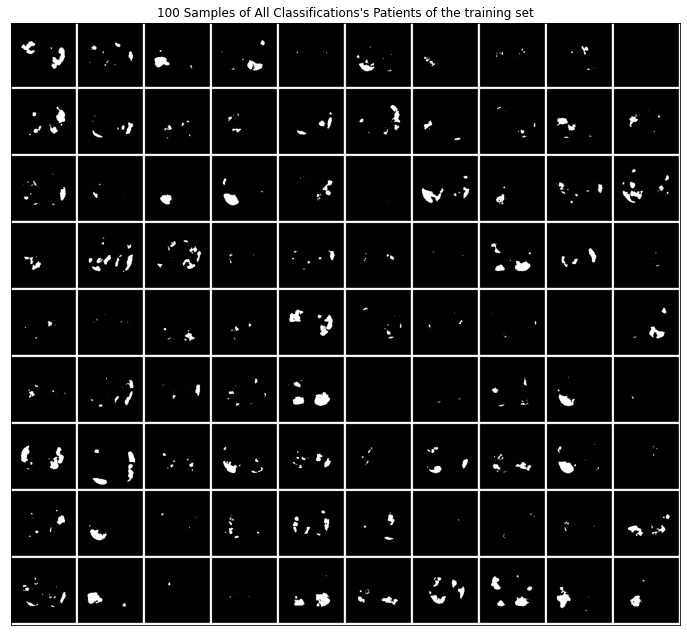

In [70]:
show_gallery("all")

Data Generator

In [71]:
def get_data_generator(dataframe, x_col, y_col, subset=None, shuffle=True, batch_size=16, class_mode="binary"):
    datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=False,
    width_shift_range=0.1,
    height_shift_range=0.1)
    
    data_generator = datagen.flow_from_dataframe(
        dataframe=dataframe,
        x_col=x_col,
        y_col=y_col,
        subset=subset,
        target_size=(width, height),
        class_mode=class_mode,
        # color_mode="rgb",
        batch_size=batch_size,
        shuffle=shuffle,
    )
    return data_generator

See sample generated images

Found 1 validated image filenames belonging to 1 classes.


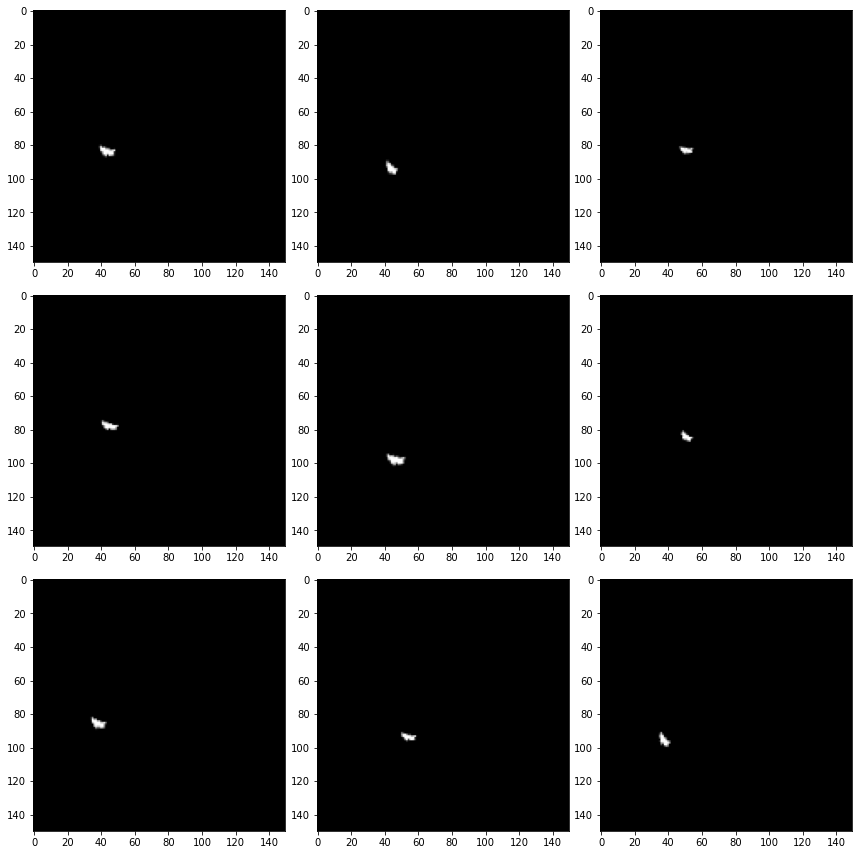

In [72]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = get_data_generator(example_df, "id", "label", class_mode = "categorical")

plt.figure(figsize = (12,12))
for i in range(0, 9):
        plt.subplot(3, 3, i+1)
        for X_batch, Y_batch in example_generator:
            image = X_batch[0]
            plt.imshow(image)
            break
plt.tight_layout()
plt.show()

Setting A Model With Transfer Learning

In [73]:
def get_model():
    from keras.applications import VGG16
    
    conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(width,height,3))
    
    conv_base.trainable = True
    set_trainable = False
    for layer in conv_base.layers:
        if layer.name == 'block3_conv1':
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False
    
    model = Sequential()
    model.add(conv_base)
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'sigmoid'))
    
    model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model
    

In [74]:
def train_model(model, train_df, validation_df, epochs, callbacks=[]):
    batch_size = 16
    train_generator = get_data_generator(train_df, "id", "label", batch_size=batch_size)
    validation_generator = get_data_generator(validation_df, "id", "label",batch_size=batch_size)

    #model.compile(
    #    optimizer="Adam", loss="binary_crossentropy", metrics=["accuracy"]
    #)

    step_size_train = train_generator.n // train_generator.batch_size
    step_size_validation = validation_generator.n // validation_generator.batch_size

    if step_size_train == 0:
        step_size_train = train_generator.n // 2
        step_size_validation = validation_generator.n // 2

    history = model.fit(
        train_generator,
        steps_per_epoch=step_size_train,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=step_size_validation,
        callbacks=callbacks
    )
    
    #needed when a model is loaded
    np.save('transfer_learning_legend', train_generator.class_indices)
    
    return history.history

In [75]:
def plot_results(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and Validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

    plt.show()

Cross Validation

In [76]:
def get_dicts(train_folders_1, train_folders_2, validation_folders_1, validation_folders_2):
    train_set = dict(zip(train_folders_1, ['other' for i in range(len(train_folders_1))]))
    train_set.update(dict(zip(train_folders_2, ['covid' for i in range(len(train_folders_2))])))
    validation_set = dict(zip(validation_folders_1, ['other' for i in range(len(validation_folders_1))]))
    validation_set.update(dict(zip(validation_folders_2, ['covid' for i in range(len(validation_folders_2))])))
    return train_set, validation_set

In [77]:
def get_data(train_img_src_folder, train_img_folders, validation_img_src_folder, validation_img_folders):   
    dfs = []
    train_images = {"id": [], "label": []}
    validation_images = {"id": [], "label": []}

    df_config = [
        (train_img_src_folder, train_img_folders, train_images),
        (validation_img_src_folder, validation_img_folders, validation_images)
    ]
    
    for (base, folder, dic) in df_config:
        for img_folder, img_label in folder.items():
            search_folder = "{}/{}".format(base, img_folder)
            imgs_filename = sorted(get_file_path(search_folder, search_filter = 'segmented'))
            imgs_filename = imgs_filename[(len(imgs_filename)-EXAM_SLICE)//2:(len(imgs_filename)+EXAM_SLICE)//2]
            dic["id"].extend(imgs_filename)
            dic["label"].extend([img_label] * len(imgs_filename))

        dfs.append(pd.DataFrame(data=dic))

    train_df, validation_df = dfs[0], dfs[1]

    train_df.to_csv('train_df.csv', index=False)
    validation_df.to_csv('validation_df.csv', index=False)

    print("Train fold with {} images".format(len(train_df)))
    print(train_df.groupby("label").label.count())
    print()
    print("Validation fold with {} images".format(len(validation_df)))
    print(validation_df.groupby("label").label.count())
    print("-" * 30)
    
    return train_df, validation_df

In [78]:
def plot_all_acc(results):
    for history in results:
        acc = history['accuracy']
        val_acc = history['val_accuracy']
        loss = history['loss']
        val_loss = history['val_loss']

        epochs = range(1, len(acc) + 1)
        plt.plot(epochs, acc, 'bo', label='Training acc')
        plt.plot(epochs, val_acc, 'b', label='Validation acc')
        plt.title('Training and Validation accuracy')
        plt.legend()

        #plt.figure()
        plt.show()

In [79]:
def cross_validation(label_1_patients, label_2_patients, valid_num):
    all_results = []
    for i in range(0, len(label_1_patients), valid_num):
        validation_folders_1 = label_1_patients[i:i+valid_num]
        validation_folders_2 = label_2_patients[i:i+valid_num]
        train_folders_1 = list(set(label_1_patients) - set(validation_folders_1))
        train_folders_2 = list(set(label_2_patients) - set(validation_folders_2))
        
        print('Validating Folders: ', sorted(validation_folders_1), ',', sorted(validation_folders_2))
        print('Training Folders: ', sorted(train_folders_1), ',', sorted(train_folders_2))
        
        train_img_src_folder = img_src_folder
        validation_img_src_folder = img_src_folder
        
        train_set, validation_set = get_dicts(train_folders_1, train_folders_2, validation_folders_1, validation_folders_2)
        
        EXAM_SLICE = 200
        EPOCHS = 15
        width = 150
        height = 150
        
        train_df, validation_df = get_data(train_img_src_folder, train_set, validation_img_src_folder, validation_set)
        
        model = get_model()
        #model.summary()
        history = train_model(model, train_df, validation_df, EPOCHS)
        all_results.append(history)
    
    return all_results 

In [80]:
def special_cross_validation(covid_patients, other_patients):
    all_results = []
    for i in range(0, 5):
        validation_other_patients = []
        validation_covid_patients = []
        
        validation_other_patients.append(other_patients[i])
        validation_other_patients.append(other_patients[i+5])
        
        validation_covid_patients.append(covid_patients[i])
        validation_covid_patients.append(covid_patients[i+5])
        
        train_covid_patients = list(set(covid_patients) - set(validation_covid_patients))
        train_other_patients = list(set(other_patients) - set(validation_other_patients))
        
        print('Validating Folders: ', sorted(validation_other_patients), ',', sorted(validation_covid_patients))
        print('Training Folders: ', sorted(train_other_patients), ',', sorted(train_covid_patients))
        
        train_img_src_folder = img_src_folder
        validation_img_src_folder = img_src_folder
        
        train_set, validation_set = get_dicts(train_covid_patients, train_other_patients, validation_covid_patients, validation_other_patients)
        
        EXAM_SLICE = 200
        EPOCHS = 15
        width = 150
        height = 150
        
        train_df, validation_df = get_data(train_img_src_folder, train_set, validation_img_src_folder, validation_set)
        
        model = get_model()
        #model.summary()
        history = train_model(model, train_df, validation_df, EPOCHS)
        all_results.append(history)
    
    return all_results

Fitting Cross Validation and Visualizing Results

In [81]:
sorted(other_patients)

['p1', 'p10', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9']

In [82]:
sorted(covid_patients)

['p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20']

In [83]:
covid_patients = sorted(covid_patients)
covid_patients

['p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20']

In [84]:
other_patients = sorted(other_patients)
other_patients.pop(1)
other_patients.append('p10')
other_patients

['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10']

In [85]:
results = special_cross_validation(covid_patients, other_patients)

Validating Folders:  ['p1', 'p6'] , ['p11', 'p16']
Training Folders:  ['p10', 'p2', 'p3', 'p4', 'p5', 'p7', 'p8', 'p9'] , ['p12', 'p13', 'p14', 'p15', 'p17', 'p18', 'p19', 'p20']
Train fold with 3200 images
label
covid    1600
other    1600
Name: label, dtype: int64

Validation fold with 800 images
label
covid    400
other    400
Name: label, dtype: int64
------------------------------
Found 3200 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.
Epoch 1/15
200/200 [==============================] - 142s 709ms/step - loss: 0.2856 - accuracy: 0.8631 - val_loss: 1.3776 - val_accuracy: 0.7200
Epoch 2/15
200/200 [==============================] - 109s 546ms/step - loss: 0.0550 - accuracy: 0.9797 - val_loss: 0.6325 - val_accuracy: 0.8612
Epoch 3/15
200/200 [==============================] - 102s 510ms/step - loss: 0.0317 - accuracy: 0.9922 - val_loss: 0.4121 - val_accuracy: 0.9050
Epoch 4/15
200/200 [==============================] 

Found 3200 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.
Epoch 1/15
200/200 [==============================] - 117s 587ms/step - loss: 0.2335 - accuracy: 0.8950 - val_loss: 0.6115 - val_accuracy: 0.7563
Epoch 2/15
200/200 [==============================] - 122s 609ms/step - loss: 0.0390 - accuracy: 0.9869 - val_loss: 1.0178 - val_accuracy: 0.7200
Epoch 3/15
200/200 [==============================] - 113s 564ms/step - loss: 0.0187 - accuracy: 0.9959 - val_loss: 0.9916 - val_accuracy: 0.7713
Epoch 4/15
200/200 [==============================] - 111s 557ms/step - loss: 0.0095 - accuracy: 0.9975 - val_loss: 1.9047 - val_accuracy: 0.7900
Epoch 5/15
200/200 [==============================] - 112s 561ms/step - loss: 0.0089 - accuracy: 0.9966 - val_loss: 2.1470 - val_accuracy: 0.7175
Epoch 6/15
200/200 [==============================] - 117s 587ms/step - loss: 0.0041 - accuracy: 0.9987 - val_loss: 3.2039 - val_accuracy: 0.6600
Epo

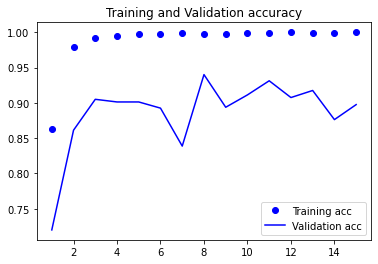

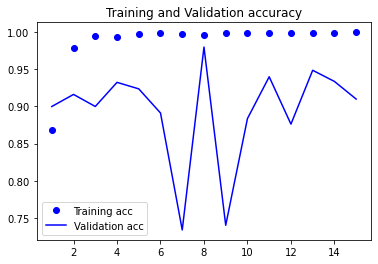

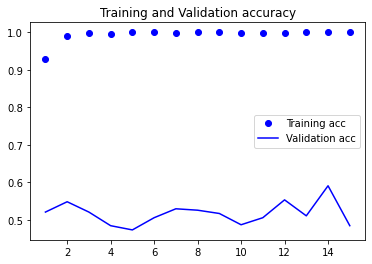

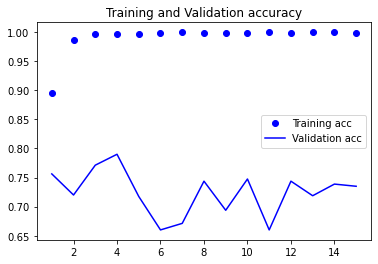

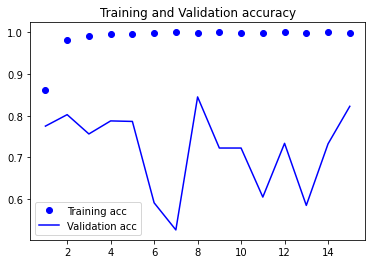

In [86]:
plot_all_acc(results)

Fitting or Loading a Final Model

In [14]:
model = get_model()

In [17]:
print(sorted(covid_patients))
print(sorted(other_patients))

['p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20']
['p1', 'p10', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9']


In [24]:
def get_file_path(folder, search_filter=''):
    paths = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            path = os.path.join(root, file)
            if search_filter in path:
                paths.append(path)
    return paths

In [29]:
#fitting a model that performed well in cross validation tests
validation_other_folders = ['p2', 'p7']
validation_covid_folders = ['p12', 'p17']

train_other_folders = list(set(other_patients) - set(validation_other_folders))
train_covid_folders = list(set(covid_patients) - set(validation_covid_folders))

print("Validating Folders: ", sorted(validation_other_folders), sorted(validation_covid_folders))
print("Training Folders: ", sorted(train_other_folders), sorted(train_covid_folders))

train_img_src_folder = img_src_folder
validation_img_src_folder = img_src_folder

train_set, validation_set = get_dicts(train_other_folders, train_covid_folders,
                                    validation_other_folders, validation_covid_folders)

train_df, validation_df = get_data(train_img_src_folder, train_set, 
                                  validation_img_src_folder, validation_set)

history = train_model(model, train_df, validation_df, EPOCHS)

Validating Folders:  ['p2', 'p7'] ['p12', 'p17']
Training Folders:  ['p1', 'p10', 'p3', 'p4', 'p5', 'p6', 'p8', 'p9'] ['p11', 'p13', 'p14', 'p15', 'p16', 'p18', 'p19', 'p20']
Train fold with 3200 images
label
covid    1600
other    1600
Name: label, dtype: int64

Validation fold with 800 images
label
covid    400
other    400
Name: label, dtype: int64
------------------------------
Found 3200 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.
Epoch 1/15
200/200 [==============================] - 140s 702ms/step - loss: 0.2459 - accuracy: 0.8953 - val_loss: 0.1848 - val_accuracy: 0.9125
Epoch 2/15
200/200 [==============================] - 122s 609ms/step - loss: 0.0407 - accuracy: 0.9869 - val_loss: 0.2954 - val_accuracy: 0.9000
Epoch 3/15
200/200 [==============================] - 44s 222ms/step - loss: 0.0188 - accuracy: 0.9944 - val_loss: 0.6703 - val_accuracy: 0.8450
Epoch 4/15
200/200 [==============================] - 41s

In [31]:
#saving the final model
model.save('transfer_learning.h5')

In [2]:
if os.path.isfile('transfer_learning.h5'):
    from keras.models import load_model
    model = load_model('transfer_learning.h5')
    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 15,076,865
Non-trainable params: 1,735,488
_________________________________________________________________


Making Predictions to Patients in Test Set

In [ ]:
test_patients = sorted(TEST_IMG_FOLDERS) 
test_patients

In [ ]:
if len(test_patients)>0:
    batch_size = 16
    width = 150
    height = 150
    results = []
    for p in test_patients:
        curr_dir = img_src_folder + '/' + p + '/segmented/' 
        test_filenames = os.listdir(curr_dir)
        test_df = pd.DataFrame({
                'filename': test_filenames
         })
        nb_samples = test_df.shape[0]

        test_gen = ImageDataGenerator(rescale=1./255)
        test_generator = test_gen.flow_from_dataframe(
                test_df, 
                curr_dir, 
                x_col='filename',
                y_col=None,
                class_mode=None,
                target_size=(width, height),
                batch_size=batch_size,
                shuffle=False
        )

        predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))
        test_df['category'] = [int(round(p[0])) for p in predict]
        results.append(test_df)

Class Activation Map

In [78]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = 'lung-segmentation/uniq/p11/segmented/132449.497359_I2350000.png'

img = image.load_img(img_path, target_size=(150,150))

x = img_to_array(img)

x = np.expand_dims(x, axis=0)

x = preprocess_input(x)
x

array([[[[ -75.939,  -96.779, -103.68 ],
         [ -75.939,  -96.779, -103.68 ],
         [ -75.939,  -96.779, -103.68 ],
         ...,
         [ -75.939,  -96.779, -103.68 ],
         [ -75.939,  -96.779, -103.68 ],
         [ -75.939,  -96.779, -103.68 ]],

        [[ -75.939,  -96.779, -103.68 ],
         [ -75.939,  -96.779, -103.68 ],
         [ -75.939,  -96.779, -103.68 ],
         ...,
         [ -75.939,  -96.779, -103.68 ],
         [ -75.939,  -96.779, -103.68 ],
         [ -75.939,  -96.779, -103.68 ]],

        [[ -75.939,  -96.779, -103.68 ],
         [ -75.939,  -96.779, -103.68 ],
         [ -75.939,  -96.779, -103.68 ],
         ...,
         [ -75.939,  -96.779, -103.68 ],
         [ -75.939,  -96.779, -103.68 ],
         [ -75.939,  -96.779, -103.68 ]],

        ...,

        [[ -75.939,  -96.779, -103.68 ],
         [ -75.939,  -96.779, -103.68 ],
         [ -75.939,  -96.779, -103.68 ],
         ...,
         [ -75.939,  -96.779, -103.68 ],
         [ -75.939,  -

In [45]:
if os.path.isfile('transfer_learning_legend.npy'):
        class_indices = np.load('transfer_learning_legend.npy', allow_pickle=True).item()
        class_indices = dict((v,k) for k,v in class_indices.items())

In [46]:
class_indices

{0: 'covid', 1: 'other'}

In [84]:
a = [int(round(p[0])) for p in preds]
class_indices[a[0]]

'covid'

In [80]:
preds = model.predict(x)
predictions = pd.DataFrame(decode_predictions(preds, top=3)[0],columns=['col1','category','probability']).iloc[:,1:]

ValueError: `decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Found array with shape: (1, 1)

In [77]:
from keras import backend as K

covid_output = model.output[:, 0]
covid_output

last_conv_layer = model.get_layer('vgg16')
last_conv_layer = last_conv_layer.get_layer('block5_conv3')

grads = K.gradients(covid_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2))

AttributeError: 'NoneType' object has no attribute 'dtype'

In [55]:
img_path_y = 'lung-segmentation/uniq/p5/segmented/144924.394315_I1680000.png'

img_y = image.load_img(img_path_y, target_size=(150,150))

y = img_to_array(img_y)

y = np.expand_dims(y, axis=0)

y = preprocess_input(y)

In [56]:
preds_y = model.predict(y)

In [57]:
preds_y

array([[1.]], dtype=float32)